# Building a RAG System for Open-Domain QA

**Overview**  
1. Load & slice Wikipedia  
2. Build paragraph list  
3. Filter & encode with SentenceTransformer  
4. Build & query FAISS index  
5. Run extractive QA pipelines  
6. Evaluate and visualize performance  
7. Profile retrieval latency  
8. Explore embedding space with t-SNE  
9. Save & reload index  

In [6]:
# Imports
import itertools
import time

import faiss
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from datasets import load_dataset
from sentence_transformers import SentenceTransformer
from sklearn.manifold import TSNE
from transformers import pipeline
import evaluate
from IPython.display import display

## 1. Load a Streaming Wikipedia Subset

In [7]:
wiki_stream = load_dataset(
    "wikipedia", "20220301.en", split="train", streaming=True
)
wiki_subset = list(itertools.islice(wiki_stream, 5000))
print(wiki_subset[0])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/16.0k [00:00<?, ?B/s]

wikipedia.py:   0%|          | 0.00/36.7k [00:00<?, ?B/s]

The repository for wikipedia contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/wikipedia.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y
{'id': '12', 'url': 'https://en.wikipedia.org/wiki/Anarchism', 'title': 'Anarchism', 'text': 'Anarchism is a political philosophy and movement that is sceptical of authority and rejects all involuntary, coercive forms of hierarchy. Anarchism calls for the abolition of the state, which it holds to be unnecessary, undesirable, and harmful. As a historically left-wing movement, placed on the farthest left of the political spectrum, it is usually described alongside communalism and libertarian Marxism as the libertarian wing (libertarian socialism) of the socialist movement, and has a strong historical association with anti-capitalism and socialism.\n\nHumans lived in societies withou

## 2. Build Paragraph & Title Lists

In [8]:
paras, titles = [], []
for entry in wiki_subset:
    t = entry["title"]
    for p in entry["text"].split("\n"):
        p = p.strip()
        if p:
            paras.append(p)
            titles.append(t)
print("Total paras:", len(paras))

Total paras: 525665


## 3. Filter by Length & Encode Paragraphs

In [9]:
paras_filtered = [p for p in paras if 20 < len(p.split()) < 200]
device = "cuda" if torch.cuda.is_available() else "cpu"
st_model = SentenceTransformer("all-MiniLM-L6-v2", device=device)
embeddings = st_model.encode(
    paras_filtered, batch_size=128, show_progress_bar=True, convert_to_numpy=True
)
print(len(paras_filtered), "paras →", embeddings.shape)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/1438 [00:00<?, ?it/s]

184051 paras → (184051, 384)


### 3.1 Paragraph Length Distribution

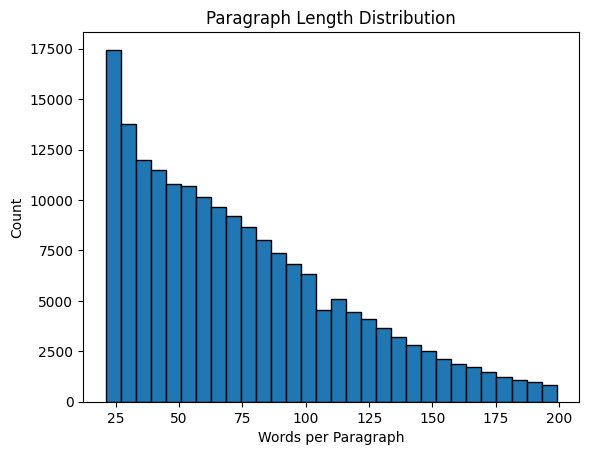

In [10]:
lengths = [len(p.split()) for p in paras_filtered]
plt.hist(lengths, bins=30, edgecolor="k")
plt.title("Paragraph Length Distribution")
plt.xlabel("Words per Paragraph")
plt.ylabel("Count")
plt.show()

## 4. Build & Query FAISS Index

In [11]:
d = embeddings.shape[1]
index = faiss.IndexFlatL2(d)
index.add(embeddings)

def retrieve_faiss(query, top_k=5):
    q_emb = st_model.encode([query], convert_to_numpy=True)
    D, I = index.search(q_emb, top_k)
    return [(paras_filtered[i], float(D[0,j])) for j,i in enumerate(I[0])]

## 5. Initialize & Run Extractive QA Pipelines

In [12]:
device_id = 0 if torch.cuda.is_available() else -1
qa_models = {
    "DeBERTa": pipeline("question-answering",
        model="deepset/deberta-v3-large-squad2",
        tokenizer="deepset/deberta-v3-large-squad2",
        device=device_id),
    "RoBERTa": pipeline("question-answering",
        model="deepset/roberta-large-squad2",
        tokenizer="deepset/roberta-large-squad2",
        device=device_id),
    "BERT": pipeline("question-answering",
        model="bert-large-uncased-whole-word-masking-finetuned-squad",
        tokenizer="bert-large-uncased-whole-word-masking-finetuned-squad",
        device=device_id),
}

metric = evaluate.load("squad")
qa_pairs = [
    ("What is the capital of France?", "Paris"),
    ("Who wrote Hamlet?", "William Shakespeare"),
    ("The Big Apple is a nickname for which city?", "New York City")
]

results = []
for name, qa in qa_models.items():
    preds, refs = [], []
    for q, a in qa_pairs:
        hits = retrieve_faiss(q, top_k=5)
        context = " ".join(p for p, _ in hits)
        out = qa(question=q, context=context)
        preds.append(out["answer"].strip())
        refs.append(a)
    preds_fmt = [{"id":str(i),"prediction_text":p} for i,p in enumerate(preds)]
    refs_fmt  = [{"id":str(i),"answers":{"text":[r],"answer_start":[0]}}
                 for i,r in enumerate(refs)]
    res = metric.compute(predictions=preds_fmt, references=refs_fmt)
    results.append({"Model": name,
                    "Exact Match": res["exact_match"],
                    "F1 Score": res["f1"]})
df = pd.DataFrame(results)

config.json:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.74G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/392 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/8.65M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/18.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

Device set to use cuda:0


config.json:   0%|          | 0.00/696 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Device set to use cuda:0


config.json:   0%|          | 0.00/443 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-large-uncased-whole-word-masking-finetuned-squad were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Device set to use cuda:0


## 6. Display & Visualize QA Performance

,Model,Exact Match,F1 Score
0,DeBERTa,66.666667,66.666667
1,RoBERTa,33.333333,33.333333
2,BERT,66.666667,66.666667


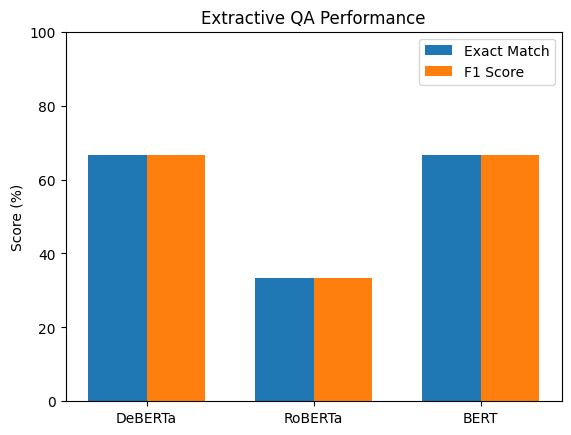

In [13]:
display(df)
x = np.arange(len(df))
w = 0.35
plt.bar(x-w/2, df["Exact Match"], w, label="Exact Match")
plt.bar(x+w/2, df["F1 Score"],  w, label="F1 Score")
plt.xticks(x, df["Model"])
plt.ylim(0,100)
plt.ylabel("Score (%)")
plt.title("Extractive QA Performance")
plt.legend()
plt.show()

## 7. Profile FAISS Retrieval Latency

Avg time: 0.0322s


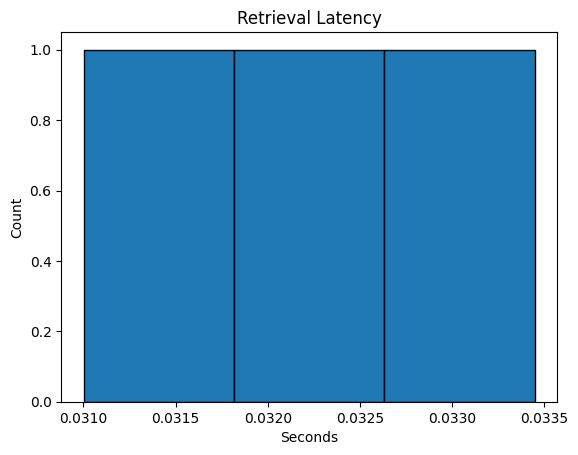

In [14]:
queries = [
    "What is Retrieval-Augmented Generation?",
    "Explain FAISS in one sentence.",
    "How do you generate embeddings?"
]
times = []
for q in queries:
    t0 = time.time()
    _ = retrieve_faiss(q)
    times.append(time.time()-t0)
print("Avg time:", f"{np.mean(times):.4f}s")
plt.hist(times, bins=len(times), edgecolor="k")
plt.title("Retrieval Latency")
plt.xlabel("Seconds")
plt.ylabel("Count")
plt.show()

## 8. Embedding-Space t-SNE Visualization

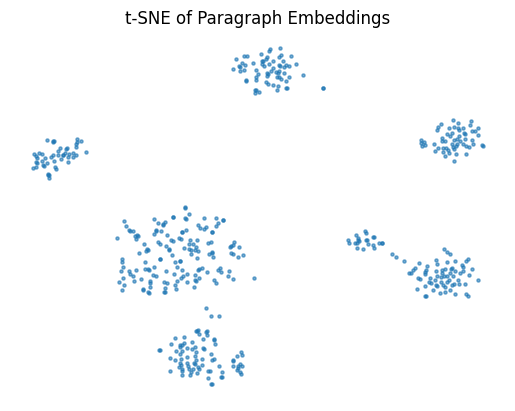

In [15]:
coords = TSNE(n_components=2, random_state=42).fit_transform(embeddings[:500])
plt.scatter(coords[:,0], coords[:,1], s=5, alpha=0.6)
plt.title("t-SNE of Paragraph Embeddings")
plt.axis("off")
plt.show()

## 9. Save & Reload FAISS Index

In [16]:
faiss.write_index(index, "rag_index.faiss")
np.save("rag_embeddings.npy", embeddings)
# To reload:
# index2 = faiss.read_index("rag_index.faiss")
# em2 = np.load("rag_embeddings.npy")